In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import copy

In [18]:
batch_size = 64
num_epochs = 30
early_stop_patience = 5
data_dir = '../data/cifar10'

In [19]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010])
])

train_dataset = datasets.CIFAR10(root= data_dir, train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root= data_dir, train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.alexnet(pretrained=False)
model.classifier[6] = nn.Linear(4096, 10)
model.to(device)

def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(init_weights)

# for param in model.parameters():
#     param.requires_grad = True

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_losses, test_losses, train_accs, test_accs = [], [], [], []
best_loss = float('inf')
patience = 0
best_epoch = 0
best_model = None

for epoch in range(num_epochs):
    model.train()
    total, correct, train_loss = 0, 0, 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    acc = correct / total
    train_losses.append(train_loss / len(train_loader))
    train_accs.append(acc)

    model.eval()
    total, correct, val_loss = 0, 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            val_loss += criterion(out, y).item()
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)

    val_acc = correct / total
    test_losses.append(val_loss / len(test_loader))
    test_accs.append(val_acc)

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f} | Train Acc: {acc:.4f} | Test Acc: {val_acc:.4f}")

    if test_losses[-1] < best_loss:
        best_loss = test_losses[-1]
        best_model = copy.deepcopy(model.state_dict())
        best_epoch = epoch + 1
        patience = 0
    else:
        patience += 1
        if patience >= early_stop_patience:
            print(f"\n🛑 Early stopping triggered at epoch {epoch+1}. Best model was from epoch {best_epoch}.")
            break


Epoch 01 | Train Loss: 1.4230 | Test Loss: 1.0134 | Train Acc: 0.4862 | Test Acc: 0.6439
Epoch 02 | Train Loss: 0.9352 | Test Loss: 0.8078 | Train Acc: 0.6736 | Test Acc: 0.7168
Epoch 03 | Train Loss: 0.7375 | Test Loss: 0.7038 | Train Acc: 0.7428 | Test Acc: 0.7596
Epoch 04 | Train Loss: 0.6145 | Test Loss: 0.6306 | Train Acc: 0.7845 | Test Acc: 0.7863
Epoch 05 | Train Loss: 0.5190 | Test Loss: 0.5745 | Train Acc: 0.8199 | Test Acc: 0.8058
Epoch 06 | Train Loss: 0.4409 | Test Loss: 0.6091 | Train Acc: 0.8460 | Test Acc: 0.7988
Epoch 07 | Train Loss: 0.3708 | Test Loss: 0.5791 | Train Acc: 0.8710 | Test Acc: 0.8119
Epoch 08 | Train Loss: 0.3061 | Test Loss: 0.5933 | Train Acc: 0.8934 | Test Acc: 0.8100
Epoch 09 | Train Loss: 0.2590 | Test Loss: 0.5800 | Train Acc: 0.9093 | Test Acc: 0.8159
Epoch 10 | Train Loss: 0.2235 | Test Loss: 0.5620 | Train Acc: 0.9202 | Test Acc: 0.8260
Epoch 11 | Train Loss: 0.1870 | Test Loss: 0.6018 | Train Acc: 0.9336 | Test Acc: 0.8185
Epoch 12 | Train Loss

In [22]:
if best_model is not None:
    model.load_state_dict(best_model)

model.eval()
correct, total = 0, 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        correct += (model(x).argmax(1) == y).sum().item()
        total += y.size(0)

print(f"\n✅ Final CIFAR10 Test Accuracy (best model): {correct / total:.4f}")


✅ Final CIFAR10 Test Accuracy (best model): 0.8260


In [23]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        outputs = model(x)
        preds = outputs.argmax(1).cpu()
        all_preds.extend(preds.numpy())
        all_labels.extend(y.numpy())

print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes if hasattr(test_dataset, 'classes') else [str(i) for i in range(10)]))



📊 Classification Report:
              precision    recall  f1-score   support

    airplane       0.87      0.84      0.85      1000
  automobile       0.92      0.90      0.91      1000
        bird       0.81      0.73      0.77      1000
         cat       0.65      0.72      0.69      1000
        deer       0.79      0.81      0.80      1000
         dog       0.76      0.74      0.75      1000
        frog       0.89      0.86      0.87      1000
       horse       0.90      0.82      0.86      1000
        ship       0.86      0.93      0.89      1000
       truck       0.84      0.91      0.88      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



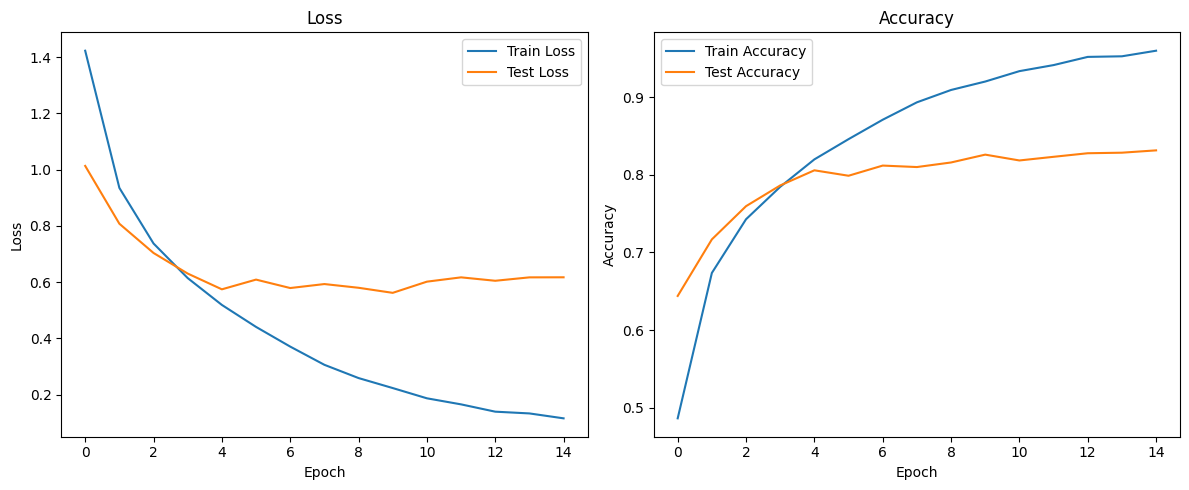

In [24]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(test_accs, label="Test Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
print(train_losses)
print(test_losses)
print(train_accs)
print(test_accs)

[1.4230077847495408, 0.9352213838673613, 0.7375023754508904, 0.6145017422602305, 0.5190378896263249, 0.44085481795279874, 0.3708498105025657, 0.30613426525917503, 0.2589804098019591, 0.22345513397889674, 0.18701513543667847, 0.1654538874638855, 0.1394797050837151, 0.13324279343837972, 0.115774012702491]
[1.0134029608623238, 0.8078023586303565, 0.7037865659993165, 0.6305852300801854, 0.5745451461737323, 0.6091041431115691, 0.5791130639185571, 0.5932711505206527, 0.5800288458159015, 0.5620130921245381, 0.6017970030854463, 0.6171200916076162, 0.6049556147520709, 0.6170653793367611, 0.6173166188464803]
[0.48622, 0.67356, 0.74276, 0.78452, 0.81988, 0.84596, 0.87098, 0.8934, 0.90932, 0.92018, 0.93358, 0.94138, 0.95194, 0.9527, 0.9599]
[0.6439, 0.7168, 0.7596, 0.7863, 0.8058, 0.7988, 0.8119, 0.81, 0.8159, 0.826, 0.8185, 0.8232, 0.8278, 0.8285, 0.8315]
